# **Libraries**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import skimage
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPU teh Run korte chaile look into this.

## **Data Loading and Pre-processing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/MyDrive/CSE428/Project/Dataset_BUSI_with_GT'
# os.makedirs(BASE_DIR, exist_ok=True) #eitah on korbi intially jodi kono file set na kora thake.
MODEL_SAVE_PATH = '/content/drive/MyDrive/CSE428/Project/ProjectSubmission/best_model.pth'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

# print("Path to dataset files:", path)

Data_loading

In [ ]:
def read_folder_data(base_dir, img_size=256):
    x = []
    y_mask = []
    y_label = []

    classes = {'normal': 0, 'benign': 1, 'malignant': 2} #check this!
    for class_name, label_idx in classes.items():
        class_dir = os.path.join(base_dir, class_name)

        if not os.path.isdir(class_dir): #precaution block (Folder na thakle error dhorte easy.)
            print(f"{class_dir} does not exist")
            continue
        print(f"Processing {class_name}")

        files = os.listdir(class_dir)
        image_files = [f for f in files if "_mask" not in f] #UnMask and Mask file alada kora hoise eikhane

        for img_file in tqdm(image_files, desc=f"Loading {class_name}"): #Path Bananor jonno
            img_path = os.path.join(class_dir, img_file)
            mask_file = img_file.replace(".", "_mask.")
            mask_path = os.path.join(class_dir, mask_file)

            if not os.path.exists(mask_path): #precaution block (Kun tar Mask nai, dhorte easy.)
                print(f"Skip, Mask not found for {img_file}")
                continue

            # NumPy Array teh nitese.
            img = plt.imread(img_path)
            if len(img.shape) == 3:  #RGB -> GS
                img = skimage.color.rgb2gray(img)
            mask = plt.imread(mask_path)
            if len(mask.shape) == 3:  #RGB->Bin
                mask = (mask[:, :, 0] > 0) | (mask[:, :, 1] > 0) | (mask[:, :, 2] > 0)


            img = skimage.transform.resize(img, (img_size, img_size), anti_aliasing=True)
            mask = skimage.transform.resize(mask, (img_size, img_size), anti_aliasing=False)
            mask = (mask > 0.5).astype(np.float32) #ekta kore mask er pixel Binary teh ane (Confirmation)

            x.append(img)
            y_mask.append(mask)
            y_label.append(label_idx)

    return np.array(x), np.array(y_mask), np.array(y_label)

Normalization and Transformation

In [ ]:
def normalize(images):
    return (images - images.mean(axis=(1, 2), keepdims=True)) / (images.std(axis=(1, 2), keepdims=True) + 1e-8)

In [ ]:
def get_transforms(p=0.5): #Probabibility change korte chaile eikhane korbi.

    def apply_transforms(image, mask):
        image = np.copy(image)
        mask = np.copy(mask)

        if np.random.random() < p: #Horizontal
            image = np.fliplr(image)
            mask = np.fliplr(mask)
        if np.random.random() < p: #Vertical
            image = np.flipud(image)
            mask = np.flipud(mask)
        if np.random.random() < p: #Rotation
            angle = np.random.uniform(-30, 30)
            image = skimage.transform.rotate(image, angle, preserve_range=True)
            mask = skimage.transform.rotate(mask, angle, preserve_range=True, order=0)
        return np.copy(image), np.copy(mask)

    return apply_transforms

Custom DS for BreastUltrasound.

In [ ]:
class BreastUltrasoundDataset(Dataset):

    def __init__(self, images, masks, labels, transform=None):
        self.images = images
        self.masks = masks
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = np.copy(self.images[idx])
        mask = np.copy(self.masks[idx])
        label = self.labels[idx]

        if self.transform:
            image, mask = self.transform(image, mask)

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  #unsqueeze()-> er kaj google korish
        mask = torch.tensor(mask, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, mask, label

# Model Architecture

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [ ]:
# class AttentionGate(nn.Module):
#     def __init__(self, F_g, F_l, F_int):
#         super(AttentionGate, self).__init__()
#         self.W_g = nn.Sequential(
#             nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(F_int)
#             )

In [ ]:
class MultiTaskUNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=3, base_filters=32):
        super(MultiTaskUNet, self).__init__()
        self.base_filters = base_filters

        # Encoder
        self.enc1 = ConvBlock(in_channels, base_filters)
        self.enc2 = ConvBlock(base_filters, base_filters*2)
        self.enc3 = ConvBlock(base_filters*2, base_filters*4)
        self.enc4 = ConvBlock(base_filters*4, base_filters*8)

        self.bottleneck = ConvBlock(base_filters*8, base_filters*16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder for segmentation
        self.upconv4 = nn.ConvTranspose2d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(base_filters*16, base_filters*8)

        self.upconv3 = nn.ConvTranspose2d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose2d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose2d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_filters*2, base_filters)

        self.seg_output = nn.Conv2d(base_filters, 1, kernel_size=1)

        # Classification head
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.cls_fc1 = nn.Linear(base_filters*16, base_filters*4)
        self.cls_fc2 = nn.Linear(base_filters*4, num_classes)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e1_pool = self.pool(e1)

        e2 = self.enc2(e1_pool)
        e2_pool = self.pool(e2)

        e3 = self.enc3(e2_pool)
        e3_pool = self.pool(e3)

        e4 = self.enc4(e3_pool)
        e4_pool = self.pool(e4)

        # Bottleneck
        b = self.bottleneck(e4_pool)

        # Classification path
        cls_features = self.global_pool(b).view(b.size(0), -1)  # Global pooling and flatten
        cls_features = F.relu(self.cls_fc1(cls_features))
        cls_output = self.cls_fc2(cls_features)

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        seg_output = self.seg_output(d1)

        return seg_output, cls_output

# Metrics and Loss Functions

In [ ]:
def calculate_iou(y_pred, y_true, threshold=0.5, eps=1e-6):
    # Apply sigmoid to convert logits to probabilities
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_pred = y_pred.view(y_pred.shape[0], -1)
    y_true = y_true.view(y_true.shape[0], -1)

    intersection = (y_pred * y_true).sum(dim=1)
    union = y_pred.sum(dim=1) + y_true.sum(dim=1) - intersection

    iou = (intersection + eps) / (union + eps)

    return iou.mean()

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)

        # Flatten tensors
        y_pred = y_pred.view(y_pred.shape[0], -1)
        y_true = y_true.view(y_true.shape[0], -1)

        intersection = (y_pred * y_true).sum(dim=1)
        dice = (2. * intersection + self.smooth) / (y_pred.sum(dim=1) + y_true.sum(dim=1) + self.smooth)

        return 1 - dice.mean()

In [ ]:
def calculate_classification_metrics(y_true, y_pred, class_names=['Normal', 'Benign', 'Malignant']):

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1 = np.mean(f1)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1': avg_f1
    }

    print(classification_report(y_true, y_pred, target_names=class_names))

    return metrics

# Training and Evaluaion

In [ ]:
def train_model_with_eval(base_dir, base_filters=32, batch_size=8,
                num_epochs=50, learning_rate=0.001, img_size=256, save_path='best_model.pth'):
    print("Reading and preprocessing data...")
    x, y_mask, y_label = read_folder_data(base_dir, img_size=img_size)


    print(f"Dataset shape - Images: {x.shape}")
    print(f"Class distribution: {np.bincount(y_label)}")

    x_train, x_val, y_mask_train, y_mask_val, y_label_train, y_label_val = train_test_split(
        x, y_mask, y_label, test_size=0.2, stratify=y_label, random_state=42)

    x_train = normalize(x_train)
    x_val = normalize(x_val)

    train_transform = get_transforms(p=0.5)
    train_dataset = BreastUltrasoundDataset(x_train, y_mask_train, y_label_train, transform=train_transform)
    val_dataset = BreastUltrasoundDataset(x_val, y_mask_val, y_label_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = MultiTaskUNet(in_channels=1, num_classes=3, base_filters=base_filters).to(device)
    print(f"Model initialized with {base_filters}")

    dice_loss = DiceLoss()
    bce_loss = nn.BCEWithLogitsLoss()

    class_weights = compute_class_weight('balanced', classes=np.unique(y_label), y=y_label)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    print(f"Class weights: {class_weights.cpu().numpy()}")

    cls_loss = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_seg_loss': [], 'val_seg_loss': [],
        'train_cls_loss': [], 'val_cls_loss': [],
        'train_dice_loss': [], 'val_dice_loss': [],
        'train_iou': [], 'val_iou': [],
        'train_accuracy': [], 'val_accuracy': []
    }

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_seg_loss, train_cls_loss = 0.0, 0.0, 0.0
        train_dice_loss, train_iou, train_correct, train_samples = 0.0, 0.0, 0, 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Training)')
        for images, masks, labels in train_pbar:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)

            optimizer.zero_grad()


            seg_outputs, cls_outputs = model(images)

            seg_bce = bce_loss(seg_outputs.squeeze(1), masks)
            seg_dice = dice_loss(seg_outputs.squeeze(1), masks)
            segmentation_loss = 0.5 * seg_bce + 0.5 * seg_dice
            classification_loss = cls_loss(cls_outputs, labels)

            # Total loss
            loss = 0.7 * segmentation_loss + 0.3 * classification_loss

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_seg_loss += segmentation_loss.item()
            train_cls_loss += classification_loss.item()
            train_dice_loss += seg_dice.item()
            train_iou += calculate_iou(seg_outputs.squeeze(1), masks).item()

            _, predicted = torch.max(cls_outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_samples += labels.size(0)

            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = train_loss / len(train_loader)
        avg_train_seg_loss = train_seg_loss / len(train_loader)
        avg_train_cls_loss = train_cls_loss / len(train_loader)
        avg_train_dice_loss = train_dice_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_train_accuracy = train_correct / train_samples

        # Validation phase
        model.eval()
        val_loss, val_seg_loss, val_cls_loss = 0.0, 0.0, 0.0
        val_dice_loss, val_iou, val_correct, val_samples = 0.0, 0.0, 0, 0

        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)')

        with torch.no_grad():
            for images, masks, labels in val_pbar:
                images, masks, labels = images.to(device), masks.to(device), labels.to(device)

                seg_outputs, cls_outputs = model(images)

                seg_bce = bce_loss(seg_outputs.squeeze(1), masks)
                seg_dice = dice_loss(seg_outputs.squeeze(1), masks)
                segmentation_loss = 0.5 * seg_bce + 0.5 * seg_dice
                classification_loss = cls_loss(cls_outputs, labels)

                loss = 0.7 * segmentation_loss + 0.3 * classification_loss

                val_loss += loss.item()
                val_seg_loss += segmentation_loss.item()
                val_cls_loss += classification_loss.item()
                val_dice_loss += seg_dice.item()
                val_iou += calculate_iou(seg_outputs.squeeze(1), masks).item()

                _, predicted = torch.max(cls_outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_samples += labels.size(0)

                val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_val_loss = val_loss / len(val_loader)
        avg_val_seg_loss = val_seg_loss / len(val_loader)
        avg_val_cls_loss = val_cls_loss / len(val_loader)
        avg_val_dice_loss = val_dice_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_accuracy = val_correct / val_samples

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_seg_loss'].append(avg_train_seg_loss)
        history['val_seg_loss'].append(avg_val_seg_loss)
        history['train_cls_loss'].append(avg_train_cls_loss)
        history['val_cls_loss'].append(avg_val_cls_loss)
        history['train_dice_loss'].append(avg_train_dice_loss)
        history['val_dice_loss'].append(avg_val_dice_loss)
        history['train_iou'].append(avg_train_iou)
        history['val_iou'].append(avg_val_iou)
        history['train_accuracy'].append(avg_train_accuracy)
        history['val_accuracy'].append(avg_val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Seg Loss: {avg_train_seg_loss:.4f}, "
              f"Cls Loss: {avg_train_cls_loss:.4f}, IoU: {avg_train_iou:.4f}, Acc: {avg_train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Seg Loss: {avg_val_seg_loss:.4f}, "
              f"Cls Loss: {avg_val_cls_loss:.4f}, IoU: {avg_val_iou:.4f}, Acc: {avg_val_accuracy:.4f}")
        print("-" * 50)

    # Load best model
    model.load_state_dict(torch.load(save_path))
    print(f"Loaded from {save_path}")

    print("\nEvaluating model on validation set...")
    # val_metrics = evaluate_model(model, val_loader, class_names=['Normal', 'Benign', 'Malignant'])

    # print("\nSegmentation Metrics:")
    # print(f"IoU: {val_metrics['segmentation']['iou']:.4f}")
    # print(f"Dice Coefficient: {val_metrics['segmentation']['dice']:.4f}")
    # print(f"Pixel Accuracy: {val_metrics['segmentation']['pixel_accuracy']:.4f}")

    # print("\nClassification Metrics:")
    # print(f"Accuracy: {val_metrics['classification']['accuracy']:.4f}")
    # print(f"Average F1 Score: {np.mean(val_metrics['classification']['f1']):.4f}")

    return model, history


# Testing and Prediction


In [ ]:
def predict(model, image_path, img_size=256):

    model.eval()

    img = plt.imread(image_path)
    if len(img.shape) == 3:
        img = skimage.color.rgb2gray(img)


    img = skimage.transform.resize(img, (img_size, img_size), anti_aliasing=True)
    img = (img - img.mean()) / (img.std() + 1e-8)

    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        seg_output, cls_output = model(img)

        seg_pred = torch.sigmoid(seg_output).squeeze().cpu().numpy()
        seg_pred = (seg_pred > 0.5).astype(np.float32)

        #Classification prediction
        cls_prob = F.softmax(cls_output, dim=1).squeeze().cpu().numpy()
        cls_pred = np.argmax(cls_prob)

    return seg_pred, cls_pred, cls_prob

# Function to test the model
def test_model_examples(model, base_dir, num_examples=2):
    class_names = ['Normal', 'Benign', 'Malignant']
    classes = {'normal': 0, 'benign': 1, 'malignant': 2}

    for class_name, class_idx in classes.items():
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_dir):
            print(f"{class_dir} does not exist")
            continue

        image_files = [f for f in os.listdir(class_dir) if "_mask" not in f]
        selected_files = np.random.choice(image_files, min(num_examples, len(image_files)), replace=False)

        for img_file in selected_files:
            img_path = os.path.join(class_dir, img_file)
            img = plt.imread(img_path)
            if len(img.shape) == 3:
                img = skimage.color.rgb2gray(img)
            img_resized = skimage.transform.resize(img, (256, 256), anti_aliasing=True)
            img_normalized = (img_resized - img_resized.mean()) / (img_resized.std() + 1e-8)

            seg_pred, cls_pred, cls_prob = predict(model, img_path, img_size=256)

            print(f"\nFile: {img_file}")
            print(f"True class: {class_name}")
            print(f"Predicted class: {class_names[cls_pred]}")
            print(f"Class probabilities: Normal: {cls_prob[0]:.4f}, Benign: {cls_prob[1]:.4f}, Malignant: {cls_prob[2]:.4f}")

            show_prediction(img_resized, seg_pred, cls_pred, cls_prob)


# Initialization for Training and Testing.

In [ ]:
model, history = train_model_with_eval(
    base_dir=BASE_DIR,
    base_filters=32,
    batch_size=8,
    num_epochs=50,
    learning_rate=0.0001,
    img_size=256,
    save_path=MODEL_SAVE_PATH
)

print("Training complete!")

#Reference er jonno disi, comment korte paros

class_names = ['Normal', 'Benign', 'Malignant']

Reading and preprocessing data...
Processing normal


Loading normal:   0%|          | 0/133 [00:00<?, ?it/s]

Processing benign


Loading benign:   0%|          | 0/437 [00:00<?, ?it/s]

Processing malignant


Loading malignant:   0%|          | 0/210 [00:00<?, ?it/s]

Dataset shape - Images: (780, 256, 256)
Class distribution: [133 437 210]
Model initialized with 32
Class weights: [1.9548873 0.5949657 1.2380953]


Epoch 1/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 1/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.8625
Epoch 1/50
Train Loss: 0.8755, Seg Loss: 0.8013, Cls Loss: 1.0486, IoU: 0.0819, Acc: 0.4359
Val Loss: 0.8625, Seg Loss: 0.8192, Cls Loss: 0.9635, IoU: 0.0976, Acc: 0.5000
--------------------------------------------------


Epoch 2/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 2/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.8284
Epoch 2/50
Train Loss: 0.8037, Seg Loss: 0.7351, Cls Loss: 0.9637, IoU: 0.1165, Acc: 0.5192
Val Loss: 0.8284, Seg Loss: 0.7915, Cls Loss: 0.9144, IoU: 0.1380, Acc: 0.6282
--------------------------------------------------


Epoch 3/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 3/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/50
Train Loss: 0.7635, Seg Loss: 0.7082, Cls Loss: 0.8925, IoU: 0.1854, Acc: 0.5913
Val Loss: 0.8908, Seg Loss: 0.7133, Cls Loss: 1.3051, IoU: 0.2237, Acc: 0.4359
--------------------------------------------------


Epoch 4/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 4/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.7391
Epoch 4/50
Train Loss: 0.7373, Seg Loss: 0.6875, Cls Loss: 0.8535, IoU: 0.2558, Acc: 0.5769
Val Loss: 0.7391, Seg Loss: 0.6778, Cls Loss: 0.8820, IoU: 0.2695, Acc: 0.6026
--------------------------------------------------


Epoch 5/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 5/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.7135
Epoch 5/50
Train Loss: 0.7030, Seg Loss: 0.6677, Cls Loss: 0.7856, IoU: 0.2723, Acc: 0.6330
Val Loss: 0.7135, Seg Loss: 0.6551, Cls Loss: 0.8495, IoU: 0.3303, Acc: 0.5513
--------------------------------------------------


Epoch 6/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 6/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.6706
Epoch 6/50
Train Loss: 0.6884, Seg Loss: 0.6500, Cls Loss: 0.7781, IoU: 0.2972, Acc: 0.6506
Val Loss: 0.6706, Seg Loss: 0.6288, Cls Loss: 0.7680, IoU: 0.4155, Acc: 0.5577
--------------------------------------------------


Epoch 7/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 7/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/50
Train Loss: 0.6684, Seg Loss: 0.6376, Cls Loss: 0.7405, IoU: 0.2934, Acc: 0.6747
Val Loss: 0.6726, Seg Loss: 0.6300, Cls Loss: 0.7720, IoU: 0.3453, Acc: 0.6154
--------------------------------------------------


Epoch 8/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 8/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/50
Train Loss: 0.6522, Seg Loss: 0.6240, Cls Loss: 0.7179, IoU: 0.2982, Acc: 0.6811
Val Loss: 0.7338, Seg Loss: 0.6527, Cls Loss: 0.9230, IoU: 0.2526, Acc: 0.6090
--------------------------------------------------


Epoch 9/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 9/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.6111
Epoch 9/50
Train Loss: 0.6558, Seg Loss: 0.6099, Cls Loss: 0.7631, IoU: 0.3263, Acc: 0.6410
Val Loss: 0.6111, Seg Loss: 0.6018, Cls Loss: 0.6328, IoU: 0.3050, Acc: 0.7372
--------------------------------------------------


Epoch 10/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 10/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.6100
Epoch 10/50
Train Loss: 0.6226, Seg Loss: 0.5947, Cls Loss: 0.6876, IoU: 0.3403, Acc: 0.6779
Val Loss: 0.6100, Seg Loss: 0.6126, Cls Loss: 0.6038, IoU: 0.2551, Acc: 0.7436
--------------------------------------------------


Epoch 11/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 11/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/50
Train Loss: 0.6139, Seg Loss: 0.5860, Cls Loss: 0.6790, IoU: 0.3406, Acc: 0.6843
Val Loss: 0.6865, Seg Loss: 0.5703, Cls Loss: 0.9575, IoU: 0.4296, Acc: 0.5833
--------------------------------------------------


Epoch 12/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 12/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/50
Train Loss: 0.5913, Seg Loss: 0.5712, Cls Loss: 0.6384, IoU: 0.3768, Acc: 0.7099
Val Loss: 0.6198, Seg Loss: 0.5617, Cls Loss: 0.7553, IoU: 0.5152, Acc: 0.5897
--------------------------------------------------


Epoch 13/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 13/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.5810
Epoch 13/50
Train Loss: 0.5721, Seg Loss: 0.5622, Cls Loss: 0.5950, IoU: 0.3725, Acc: 0.7292
Val Loss: 0.5810, Seg Loss: 0.5461, Cls Loss: 0.6622, IoU: 0.4367, Acc: 0.8013
--------------------------------------------------


Epoch 14/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 14/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/50
Train Loss: 0.5899, Seg Loss: 0.5519, Cls Loss: 0.6788, IoU: 0.4067, Acc: 0.6907
Val Loss: 0.7106, Seg Loss: 0.5522, Cls Loss: 1.0801, IoU: 0.3389, Acc: 0.7115
--------------------------------------------------


Epoch 15/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 15/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/50
Train Loss: 0.5615, Seg Loss: 0.5418, Cls Loss: 0.6073, IoU: 0.4017, Acc: 0.7228
Val Loss: 0.5913, Seg Loss: 0.5406, Cls Loss: 0.7096, IoU: 0.3848, Acc: 0.6859
--------------------------------------------------


Epoch 16/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 16/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/50
Train Loss: 0.5600, Seg Loss: 0.5320, Cls Loss: 0.6255, IoU: 0.4095, Acc: 0.7452
Val Loss: 0.6338, Seg Loss: 0.5642, Cls Loss: 0.7963, IoU: 0.3404, Acc: 0.7244
--------------------------------------------------


Epoch 17/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 17/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.5636
Epoch 17/50
Train Loss: 0.5288, Seg Loss: 0.5203, Cls Loss: 0.5487, IoU: 0.4552, Acc: 0.7564
Val Loss: 0.5636, Seg Loss: 0.4979, Cls Loss: 0.7168, IoU: 0.4959, Acc: 0.7692
--------------------------------------------------


Epoch 18/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 18/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.5040
Epoch 18/50
Train Loss: 0.5565, Seg Loss: 0.5148, Cls Loss: 0.6539, IoU: 0.4166, Acc: 0.6955
Val Loss: 0.5040, Seg Loss: 0.4923, Cls Loss: 0.5311, IoU: 0.5315, Acc: 0.8013
--------------------------------------------------


Epoch 19/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 19/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/50
Train Loss: 0.5274, Seg Loss: 0.5027, Cls Loss: 0.5851, IoU: 0.4381, Acc: 0.7452
Val Loss: 0.5166, Seg Loss: 0.4969, Cls Loss: 0.5625, IoU: 0.4755, Acc: 0.7436
--------------------------------------------------


Epoch 20/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 20/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.4784
Epoch 20/50
Train Loss: 0.5172, Seg Loss: 0.4948, Cls Loss: 0.5693, IoU: 0.4580, Acc: 0.7452
Val Loss: 0.4784, Seg Loss: 0.4881, Cls Loss: 0.4558, IoU: 0.5505, Acc: 0.7756
--------------------------------------------------


Epoch 21/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 21/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/50
Train Loss: 0.5196, Seg Loss: 0.4847, Cls Loss: 0.6012, IoU: 0.4599, Acc: 0.7292
Val Loss: 0.5520, Seg Loss: 0.4874, Cls Loss: 0.7027, IoU: 0.5052, Acc: 0.7179
--------------------------------------------------


Epoch 22/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 22/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/50
Train Loss: 0.4968, Seg Loss: 0.4801, Cls Loss: 0.5359, IoU: 0.4578, Acc: 0.7612
Val Loss: 0.6250, Seg Loss: 0.4615, Cls Loss: 1.0064, IoU: 0.5367, Acc: 0.5833
--------------------------------------------------


Epoch 23/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 23/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.4689
Epoch 23/50
Train Loss: 0.5048, Seg Loss: 0.4750, Cls Loss: 0.5745, IoU: 0.4527, Acc: 0.7388
Val Loss: 0.4689, Seg Loss: 0.4579, Cls Loss: 0.4946, IoU: 0.5101, Acc: 0.7885
--------------------------------------------------


Epoch 24/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 24/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/50
Train Loss: 0.4746, Seg Loss: 0.4636, Cls Loss: 0.5005, IoU: 0.4631, Acc: 0.7676
Val Loss: 0.5226, Seg Loss: 0.4445, Cls Loss: 0.7049, IoU: 0.5265, Acc: 0.6410
--------------------------------------------------


Epoch 25/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 25/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/50
Train Loss: 0.4884, Seg Loss: 0.4578, Cls Loss: 0.5600, IoU: 0.4672, Acc: 0.7644
Val Loss: 0.4719, Seg Loss: 0.4556, Cls Loss: 0.5099, IoU: 0.4993, Acc: 0.7628
--------------------------------------------------


Epoch 26/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 26/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.4535
Epoch 26/50
Train Loss: 0.4628, Seg Loss: 0.4475, Cls Loss: 0.4983, IoU: 0.4979, Acc: 0.7676
Val Loss: 0.4535, Seg Loss: 0.4494, Cls Loss: 0.4631, IoU: 0.5037, Acc: 0.7949
--------------------------------------------------


Epoch 27/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 27/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/50
Train Loss: 0.4714, Seg Loss: 0.4413, Cls Loss: 0.5417, IoU: 0.5109, Acc: 0.7708
Val Loss: 0.4664, Seg Loss: 0.4636, Cls Loss: 0.4728, IoU: 0.4182, Acc: 0.8077
--------------------------------------------------


Epoch 28/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 28/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.4526
Epoch 28/50
Train Loss: 0.4614, Seg Loss: 0.4386, Cls Loss: 0.5148, IoU: 0.4884, Acc: 0.7756
Val Loss: 0.4526, Seg Loss: 0.4227, Cls Loss: 0.5224, IoU: 0.6027, Acc: 0.7628
--------------------------------------------------


Epoch 29/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 29/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.4217
Epoch 29/50
Train Loss: 0.4542, Seg Loss: 0.4326, Cls Loss: 0.5045, IoU: 0.5047, Acc: 0.7869
Val Loss: 0.4217, Seg Loss: 0.4132, Cls Loss: 0.4415, IoU: 0.5770, Acc: 0.7885
--------------------------------------------------


Epoch 30/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 30/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/50
Train Loss: 0.4429, Seg Loss: 0.4227, Cls Loss: 0.4900, IoU: 0.5111, Acc: 0.7821
Val Loss: 0.5122, Seg Loss: 0.4263, Cls Loss: 0.7125, IoU: 0.5104, Acc: 0.6859
--------------------------------------------------


Epoch 31/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 31/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/50
Train Loss: 0.4388, Seg Loss: 0.4186, Cls Loss: 0.4860, IoU: 0.4882, Acc: 0.7837
Val Loss: 0.4281, Seg Loss: 0.3962, Cls Loss: 0.5026, IoU: 0.5677, Acc: 0.7436
--------------------------------------------------


Epoch 32/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 32/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.4167
Epoch 32/50
Train Loss: 0.4341, Seg Loss: 0.4104, Cls Loss: 0.4893, IoU: 0.5183, Acc: 0.7788
Val Loss: 0.4167, Seg Loss: 0.3956, Cls Loss: 0.4659, IoU: 0.5902, Acc: 0.7756
--------------------------------------------------


Epoch 33/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 33/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.4124
Epoch 33/50
Train Loss: 0.4140, Seg Loss: 0.4060, Cls Loss: 0.4326, IoU: 0.5191, Acc: 0.8109
Val Loss: 0.4124, Seg Loss: 0.3941, Cls Loss: 0.4551, IoU: 0.5662, Acc: 0.7372
--------------------------------------------------


Epoch 34/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 34/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/50
Train Loss: 0.4192, Seg Loss: 0.3935, Cls Loss: 0.4793, IoU: 0.5234, Acc: 0.7676
Val Loss: 0.4318, Seg Loss: 0.3904, Cls Loss: 0.5284, IoU: 0.5659, Acc: 0.7885
--------------------------------------------------


Epoch 35/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 35/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.4090
Epoch 35/50
Train Loss: 0.4207, Seg Loss: 0.3936, Cls Loss: 0.4837, IoU: 0.5282, Acc: 0.7837
Val Loss: 0.4090, Seg Loss: 0.3767, Cls Loss: 0.4843, IoU: 0.6080, Acc: 0.7500
--------------------------------------------------


Epoch 36/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 36/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/50
Train Loss: 0.4142, Seg Loss: 0.3913, Cls Loss: 0.4675, IoU: 0.5329, Acc: 0.7917
Val Loss: 0.4457, Seg Loss: 0.3914, Cls Loss: 0.5722, IoU: 0.5522, Acc: 0.6923
--------------------------------------------------


Epoch 37/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 37/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/50
Train Loss: 0.3972, Seg Loss: 0.3831, Cls Loss: 0.4302, IoU: 0.5401, Acc: 0.7965
Val Loss: 0.4396, Seg Loss: 0.4380, Cls Loss: 0.4433, IoU: 0.3867, Acc: 0.8013
--------------------------------------------------


Epoch 38/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 38/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/50
Train Loss: 0.4071, Seg Loss: 0.3859, Cls Loss: 0.4567, IoU: 0.5271, Acc: 0.7917
Val Loss: 0.5268, Seg Loss: 0.3866, Cls Loss: 0.8538, IoU: 0.5261, Acc: 0.6346
--------------------------------------------------


Epoch 39/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 39/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.3858
Epoch 39/50
Train Loss: 0.3972, Seg Loss: 0.3798, Cls Loss: 0.4381, IoU: 0.5359, Acc: 0.8029
Val Loss: 0.3858, Seg Loss: 0.3681, Cls Loss: 0.4270, IoU: 0.5555, Acc: 0.7885
--------------------------------------------------


Epoch 40/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 40/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.3766
Epoch 40/50
Train Loss: 0.3933, Seg Loss: 0.3701, Cls Loss: 0.4472, IoU: 0.5324, Acc: 0.7981
Val Loss: 0.3766, Seg Loss: 0.3650, Cls Loss: 0.4037, IoU: 0.5630, Acc: 0.7949
--------------------------------------------------


Epoch 41/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 41/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.3731
Epoch 41/50
Train Loss: 0.3681, Seg Loss: 0.3643, Cls Loss: 0.3770, IoU: 0.5565, Acc: 0.8269
Val Loss: 0.3731, Seg Loss: 0.3532, Cls Loss: 0.4193, IoU: 0.5996, Acc: 0.7949
--------------------------------------------------


Epoch 42/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 42/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/50
Train Loss: 0.3792, Seg Loss: 0.3567, Cls Loss: 0.4316, IoU: 0.5468, Acc: 0.8045
Val Loss: 0.4324, Seg Loss: 0.3599, Cls Loss: 0.6014, IoU: 0.5319, Acc: 0.6603
--------------------------------------------------


Epoch 43/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 43/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.3681
Epoch 43/50
Train Loss: 0.3575, Seg Loss: 0.3537, Cls Loss: 0.3662, IoU: 0.5547, Acc: 0.8301
Val Loss: 0.3681, Seg Loss: 0.3491, Cls Loss: 0.4126, IoU: 0.5440, Acc: 0.8141
--------------------------------------------------


Epoch 44/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 44/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/50
Train Loss: 0.3658, Seg Loss: 0.3530, Cls Loss: 0.3956, IoU: 0.5521, Acc: 0.8093
Val Loss: 0.3974, Seg Loss: 0.3450, Cls Loss: 0.5197, IoU: 0.6315, Acc: 0.7564
--------------------------------------------------


Epoch 45/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 45/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/50
Train Loss: 0.3626, Seg Loss: 0.3494, Cls Loss: 0.3932, IoU: 0.5702, Acc: 0.8189
Val Loss: 0.3714, Seg Loss: 0.3444, Cls Loss: 0.4344, IoU: 0.5700, Acc: 0.8397
--------------------------------------------------


Epoch 46/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 46/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.3664
Epoch 46/50
Train Loss: 0.3650, Seg Loss: 0.3473, Cls Loss: 0.4063, IoU: 0.5663, Acc: 0.8253
Val Loss: 0.3664, Seg Loss: 0.3384, Cls Loss: 0.4318, IoU: 0.6134, Acc: 0.7756
--------------------------------------------------


Epoch 47/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 47/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Saved best model with validation loss: 0.3543
Epoch 47/50
Train Loss: 0.3652, Seg Loss: 0.3478, Cls Loss: 0.4058, IoU: 0.5474, Acc: 0.8446
Val Loss: 0.3543, Seg Loss: 0.3488, Cls Loss: 0.3671, IoU: 0.5582, Acc: 0.8205
--------------------------------------------------


Epoch 48/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 48/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/50
Train Loss: 0.3496, Seg Loss: 0.3431, Cls Loss: 0.3646, IoU: 0.5639, Acc: 0.8269
Val Loss: 0.3610, Seg Loss: 0.3390, Cls Loss: 0.4122, IoU: 0.6025, Acc: 0.7692
--------------------------------------------------


Epoch 49/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 49/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/50
Train Loss: 0.3597, Seg Loss: 0.3399, Cls Loss: 0.4057, IoU: 0.5430, Acc: 0.8253
Val Loss: 0.4233, Seg Loss: 0.3327, Cls Loss: 0.6349, IoU: 0.5726, Acc: 0.7179
--------------------------------------------------


Epoch 50/50 (Training):   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 50/50 (Validation):   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/50
Train Loss: 0.3376, Seg Loss: 0.3356, Cls Loss: 0.3424, IoU: 0.5546, Acc: 0.8526
Val Loss: 0.3575, Seg Loss: 0.3248, Cls Loss: 0.4337, IoU: 0.6345, Acc: 0.8333
--------------------------------------------------
Loaded from /content/drive/MyDrive/CSE428/Project/ProjectSubmission/best_model.pth

Evaluating model on validation set...
Training complete!



File: normal (39).png
True class: normal
Predicted class: Normal
Class probabilities: Normal: 0.9599, Benign: 0.0260, Malignant: 0.0141


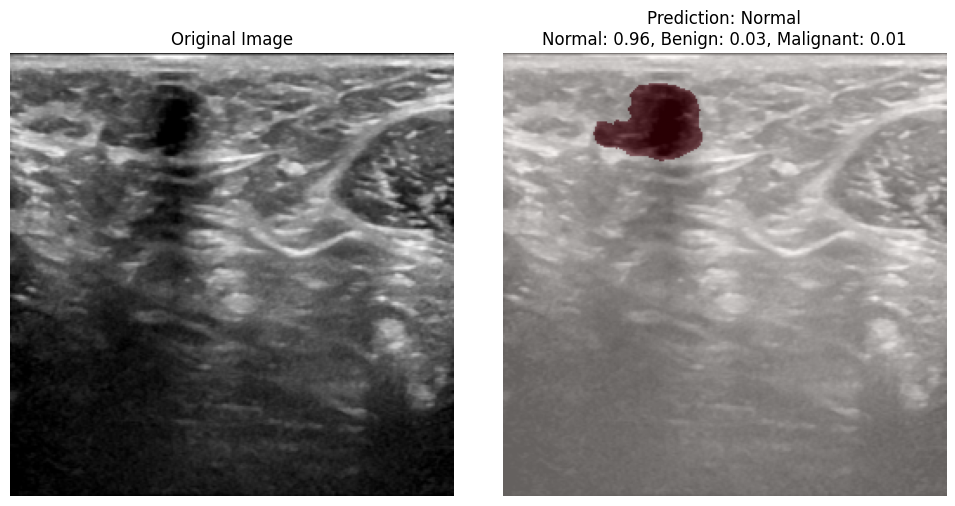


File: normal (70).png
True class: normal
Predicted class: Normal
Class probabilities: Normal: 0.9880, Benign: 0.0108, Malignant: 0.0012


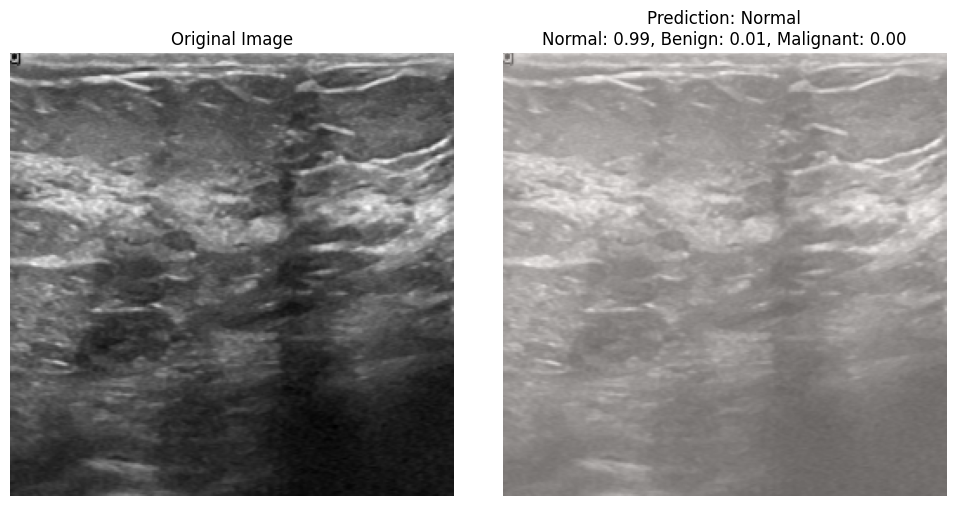


File: benign (375).png
True class: benign
Predicted class: Benign
Class probabilities: Normal: 0.2830, Benign: 0.6586, Malignant: 0.0584


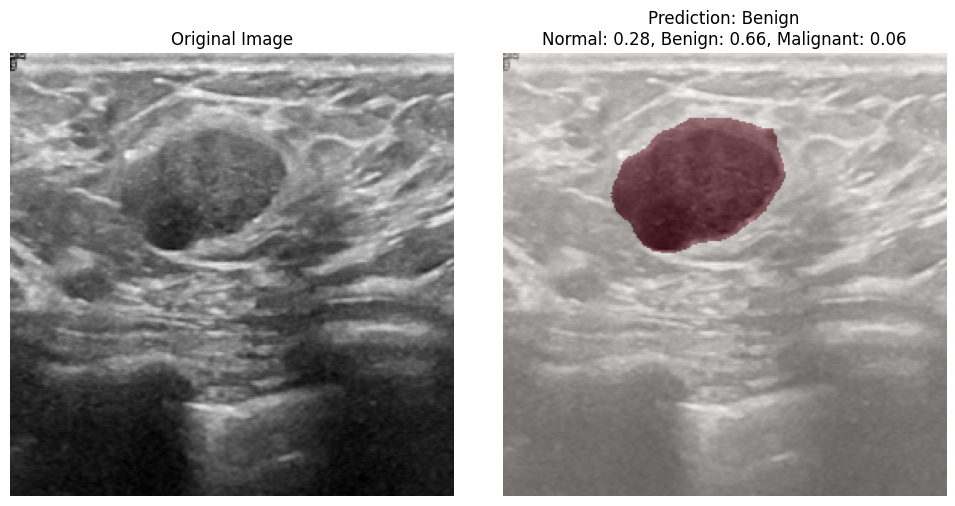


File: benign (42).png
True class: benign
Predicted class: Malignant
Class probabilities: Normal: 0.0214, Benign: 0.0791, Malignant: 0.8995


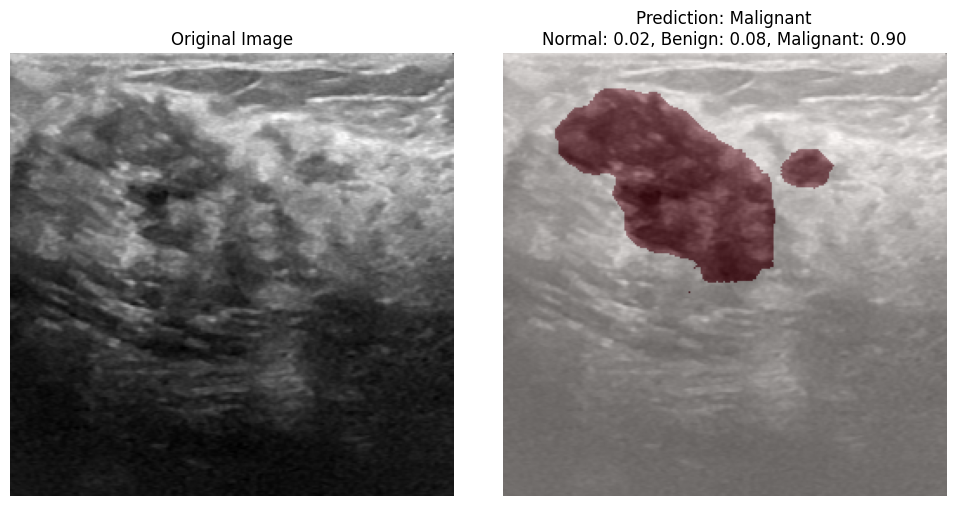


File: malignant (188).png
True class: malignant
Predicted class: Malignant
Class probabilities: Normal: 0.0042, Benign: 0.3295, Malignant: 0.6663


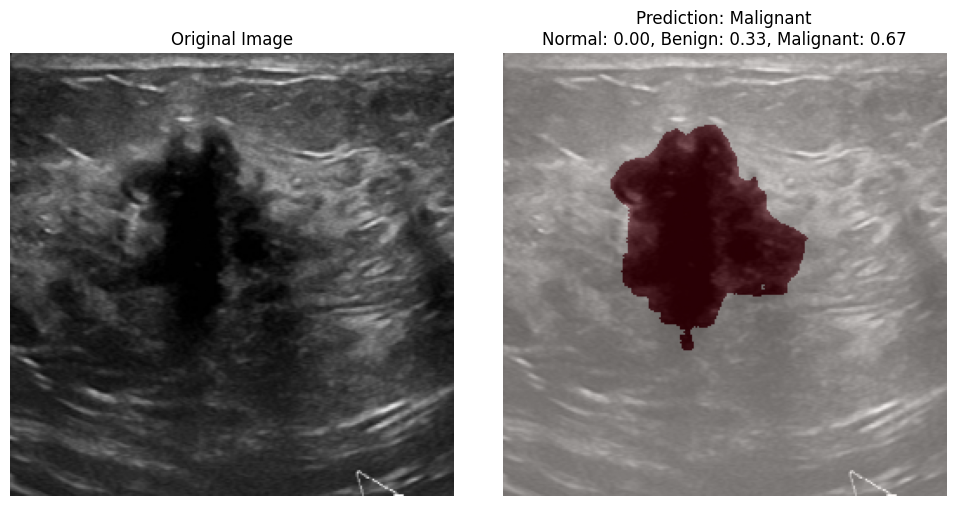


File: malignant (207).png
True class: malignant
Predicted class: Malignant
Class probabilities: Normal: 0.0008, Benign: 0.1442, Malignant: 0.8550


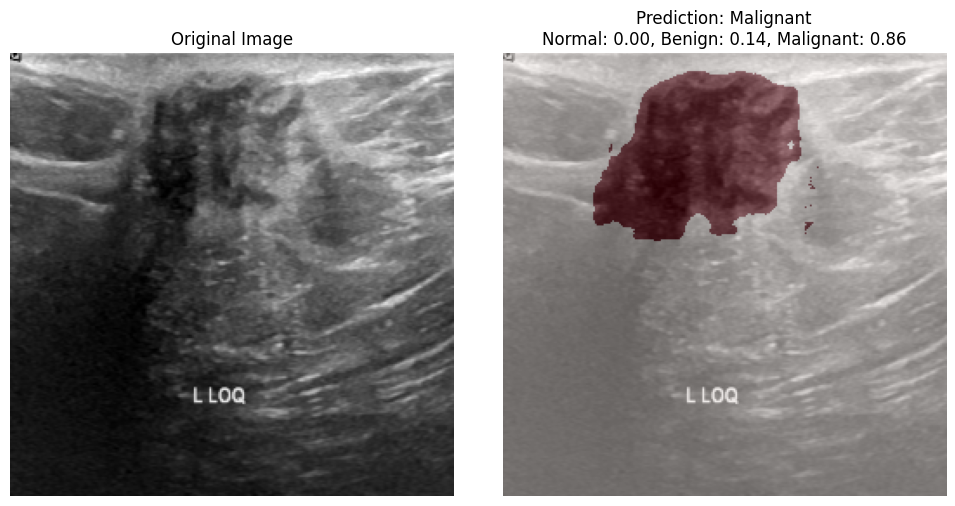

In [ ]:
test_model_examples(model, BASE_DIR, num_examples=2)

# Visualization

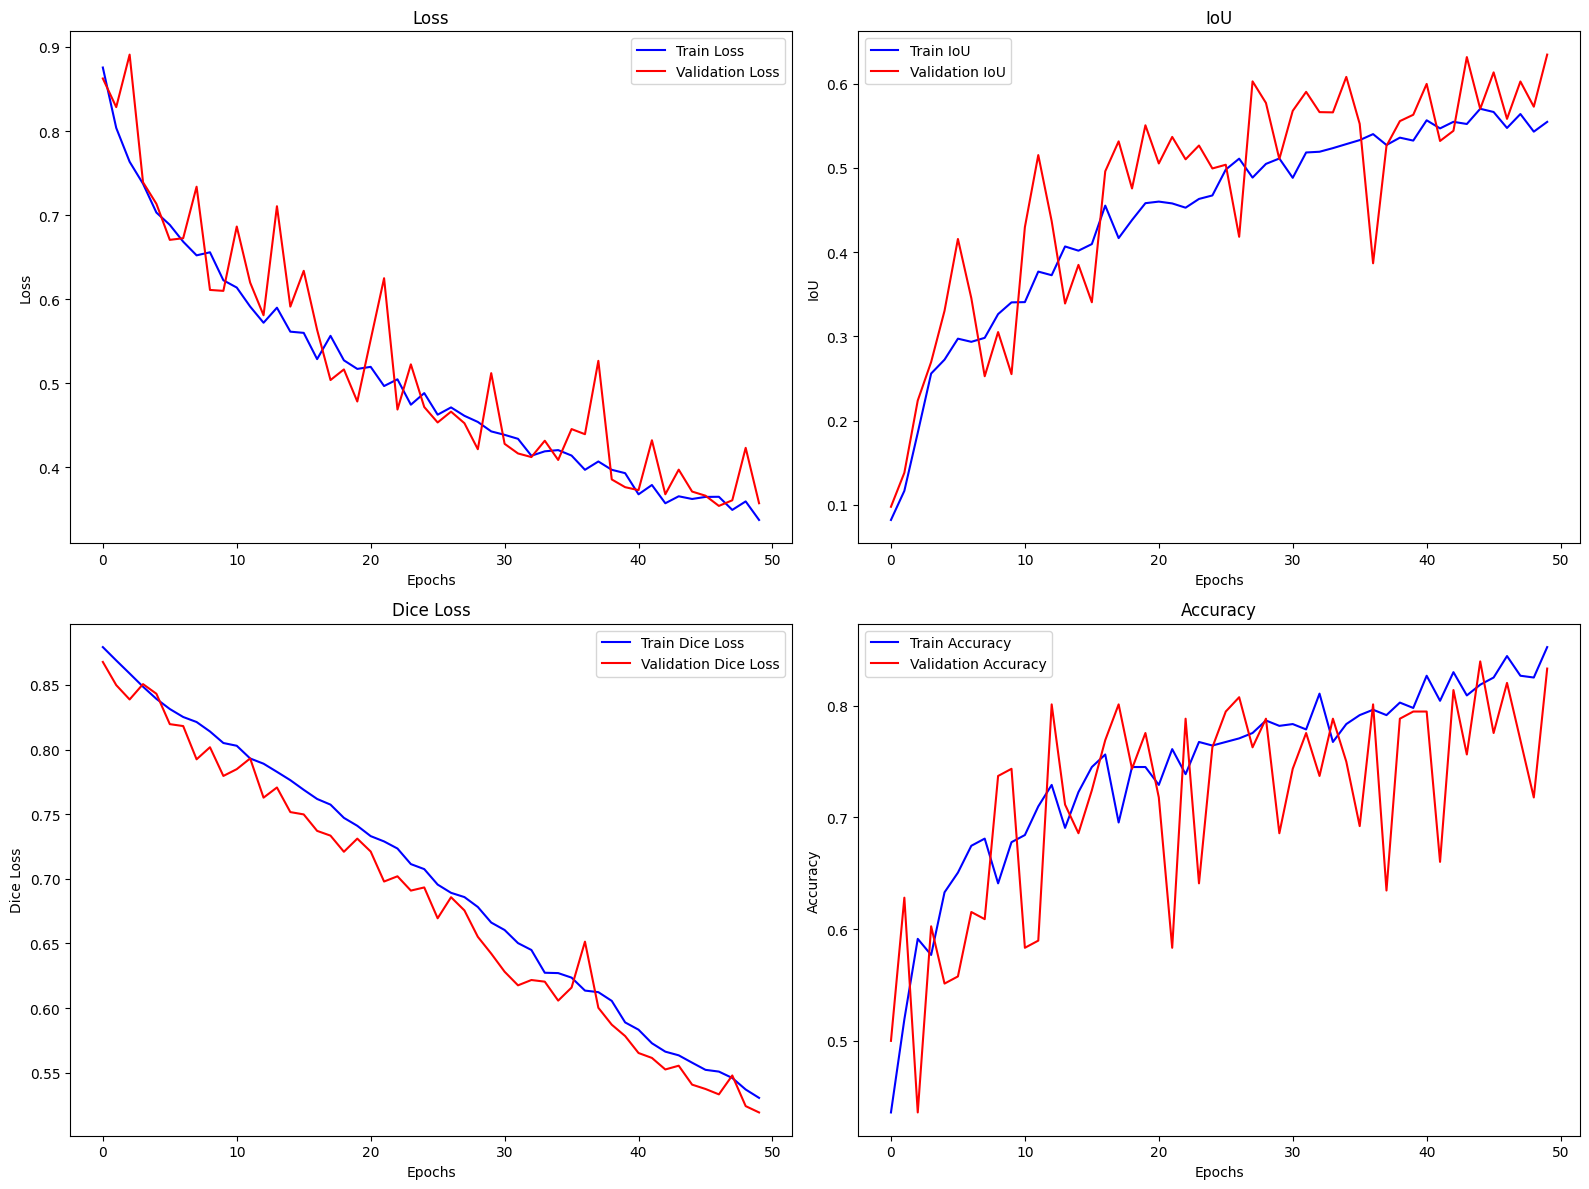

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot Losses (Train vs Validation)
    axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Plot IoU (Train vs Validation)
    axes[0, 1].plot(history['train_iou'], label='Train IoU', color='blue')
    axes[0, 1].plot(history['val_iou'], label='Validation IoU', color='red')
    axes[0, 1].set_title('IoU')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].legend()

    # Plot Dice Loss (Train vs Validation)
    axes[1, 0].plot(history['train_dice_loss'], label='Train Dice Loss', color='blue')
    axes[1, 0].plot(history['val_dice_loss'], label='Validation Dice Loss', color='red')
    axes[1, 0].set_title('Dice Loss')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Dice Loss')
    axes[1, 0].legend()

    # Plot Accuracy (Train vs Validation)
    axes[1, 1].plot(history['train_accuracy'], label='Train Accuracy', color='blue')
    axes[1, 1].plot(history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[1, 1].set_title('Accuracy')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [ ]:
import cv2
import matplotlib.pyplot as plt

def load_and_predict_single_image(model, image_path, img_size=256):
    model.eval()  # Set model to evaluation mode

    # Load image
    img = plt.imread(image_path)
    if len(img.shape) == 3:  # Convert to grayscale if RGB
        img = skimage.color.rgb2gray(img)

    # Resize and normalize
    img_resized = skimage.transform.resize(img, (img_size, img_size), anti_aliasing=True)
    img_normalized = (img_resized - img_resized.mean()) / (img_resized.std() + 1e-8)

    # Convert to tensor and reshape to match model input
    img_tensor = torch.tensor(img_normalized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        seg_output, cls_output = model(img_tensor)

        # Segmentation output
        seg_mask = torch.sigmoid(seg_output).squeeze().cpu().numpy()
        seg_mask = (seg_mask > 0.5).astype(np.uint8)

        # Classification output
        cls_probs = torch.softmax(cls_output, dim=1).squeeze().cpu().numpy()
        cls_pred = np.argmax(cls_probs)

    return img_resized, seg_mask, cls_pred, cls_probs


In [ ]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MultiTaskUNet(in_channels=1, num_classes=3, base_filters=32).to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device('cpu')))
model.eval()

unseen_images_dir = '/content/drive/MyDrive/CSE428/Project/ProjectSubmission/SamplePictures'


image_extensions = ['.jpg', '.jpeg', '.png']
image_files = [f for f in os.listdir(unseen_images_dir) if os.path.splitext(f.lower())[1] in image_extensions]

class_names = ['Normal', 'Benign', 'Malignant']

for image_file in image_files:
    image_path = os.path.join(unseen_images_dir, image_file)

    img = plt.imread(image_path)
    if len(img.shape) == 3:
        img = skimage.color.rgb2gray(img)
    img = skimage.transform.resize(img, (256, 256), anti_aliasing=True)
    img = (img - img.mean()) / (img.std() + 1e-8)  # Normalize
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        seg_output, cls_output = model(img_tensor)


    seg_pred = torch.sigmoid(seg_output).squeeze().cpu().numpy()
    seg_pred = (seg_pred > 0.5).astype(np.float32)

    cls_prob = F.softmax(cls_output, dim=1).squeeze().cpu().numpy()
    cls_pred = np.argmax(cls_prob)
    print(f"\nResults for image: {image_file}")
    print(f"Predicted Class: {class_names[cls_pred]}")
    print(f"Class Probabilities: Normal: {cls_prob[0]:.4f}, Benign: {cls_prob[1]:.4f}, Malignant: {cls_prob[2]:.4f}")


Results for image: 04.png
Predicted Class: Malignant
Class Probabilities: Normal: 0.0013, Benign: 0.0909, Malignant: 0.9077

Results for image: 03.png
Predicted Class: Normal
Class Probabilities: Normal: 0.9875, Benign: 0.0122, Malignant: 0.0003

Results for image: 02.png
Predicted Class: Malignant
Class Probabilities: Normal: 0.0014, Benign: 0.0882, Malignant: 0.9105

Results for image: 01.png
Predicted Class: Benign
Class Probabilities: Normal: 0.0017, Benign: 0.9535, Malignant: 0.0447


In [ ]:
def show_prediction(img, seg_mask, cls_pred, cls_probs):
    class_names = ['Normal', 'Benign', 'Malignant']
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='gray')
    plt.imshow(seg_mask, alpha=0.4, cmap='Reds')
    plt.title(f"Prediction: {class_names[cls_pred]}\n"
              f"Normal: {cls_probs[0]:.2f}, Benign: {cls_probs[1]:.2f}, Malignant: {cls_probs[2]:.2f}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
